In [120]:
# Approximating steady state of volume
# Authors: Zahra Aminzare, Kerry Tarrant

# Step 1: Define intital conditions and parameters.
# Step 2: Define system of equations.
# Step 3: A subset of parameters will be varied between some minimum value and 
# maximum value. Alternatively, define some baseline as the mean and define 
# a variance around that mean and draw from this distribution. The former is
# drawing samples from a uniform distribution while the latter is drawing
# from a normal distribution. The former method is a better method here since
# a baseline is not entirely known. 
# Next, consider the scale in which these samples will be drawn from. We could
# just draw from subintervals of min and max values that are of equal step size. 
# We could also draw from subintervals that vary in size on a logarithmic scale 
# -- subintervals are smaller towards the min value but larger near the max
# value.

# Initialization

In [121]:
import numpy as np
from scipy.integrate import solve_ivp
# import torch

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# plt.rc('text', usetex=False)
# plt.rc('font', family='serif')

import random
import time

## Latin hypercube sampling

In [122]:
def LHS_Call(xmin,
             xmean,
             xmax,
             xsd,
             Nsample,
             distribution,
             threshold):
    
    if Nsample==1:
        s=xmean
        return s

    if np.isscalar(xmean):
        Nparams=1
        xmean=np.array([xmean])
        xsd=np.array([xsd])
    else:
        Nparams=len(xmean)

    if distribution=='norm':
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            s[:,j] = xmean[j] + norm.ppf[P]*xsd[j]        

    if distribution=='unif':
        if xmin==0:
            xmin=1e-300
        if np.isscalar(xmin):
            Nparams=1
            xmin=np.array([xmin])
            xmax=np.array([xmax])
        else:
            Nparams=len(xmin)
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            if (xmax[j]<1 and xmin[j]<1) or (xmax[j]>1 and xmin[j]>1):
                # Same range
                if (xmax[j]/xmin[j])<threshold:
                    #
                    s[:,j]=xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(abs(np.log(xmax[j])) - abs(np.log(xmin[j])))
                    s[:,j] = np.exp(s[:,j])
            else:
                if (xmax[j]/xmin[j])<threshold:
                    s[:,j] = xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(np.log(xmax[j]) - np.log(xmin[j]))
                    s[:,j] = np.exp(s[:,j])
    if np.shape(s)[1]==1:
        return s.flatten()
    else:
        return s

In [123]:
def repeat_rand(array,
                integer):
    
    rng = np.random.default_rng()
    array = np.repeat(array,integer)
    rng.shuffle(array)
    array = array.reshape(-1,1)

    return array

# ODE System, Solver, Intial Conditions, Parameters

In [124]:
# Runs ODE with given parameter point and returns steady state of volume.
def CollectSample(params):
    
    # System of ODE
    def RHS_OHM(t,X):

        ## State variables
        naA = X[0]
        kA  = X[1]
        clA = X[2]
        wA  = X[3]

        ## Parameters
        pnka  = params.pnka
        pnkcc = params.pnkcc
        pkcc  = params.pkcc
        pncc  = params.pncc

        na_e  = params.na_e
        k_e   = params.k_e
        cl_e  = params.cl_e
        gna   = params.gna
        gk    = params.gk
        gcl   = params.gcl
        R     = params.R
        F     = params.F
        C     = params.C
        kp    = params.kp
        kna   = params.kna
        nu1   = params.nu1
        xA    = params.xA 
        zA    = params.zA
        y_e   = params.y_e


        ## Sodium pump & cotransporters

        # Constant 
        # pNA = -3*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        # pK  = 2*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        # pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        
        # Nonlinear 
        pNA = -pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        pK  = (2/3)*pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        

        ## Nernst  
        EnaA = (R)*np.log(na_e/naA)
        EkA  = (R)*np.log(k_e/kA)
        EclA = -(R)*np.log(cl_e/clA)

        ## Voltage
        VA=((F*wA)/C)*(naA+kA-clA+zA*(xA/wA))

        ## Volumes
        OsA=naA+kA+clA+xA/wA
        Oso=na_e+k_e+cl_e+y_e

        dwA= nu1*(OsA-Oso)

        ## Ions
        dnaA = (-gna*(VA-EnaA)+pNA)/(F*wA) - dwA*naA/wA
        dkA  = (-gk*(VA-EkA)+pK)/(F*wA) - dwA*kA/wA
        dclA = (gcl*(VA-EclA)+pCl)/(F*wA) - dwA*clA/wA

        ## All
        dX   = [dnaA, dkA, dclA, dwA]

        return dX

    ## Simulation time in seconds
    t0   = 0*3600
    tmax = 1*3600

    ## Initial conditions
    wA0  = params.wA0
    a    = 0.2
    clA0 = (Oso/2) - (xA/wA0)
    naA0 = a*Oso/2
    kA0  = (1-a)*Oso/2

    X_0   = [naA0, kA0, clA0, wA0]

    ## Solver
    results = solve_ivp(RHS_OHM,
                        (t0, tmax),
                        X_0,
                        method='LSODA',
                        rtol=1e-5
                        )
    
    ## Approximation of steady state of volume
    w_ss = results.y[-1,-1]

    ## Exclude NaN, negative, large values
    if np.isnan(w_ss) or (w_ss<0) or ((100*w_ss/wA0)>200):
        NaN_mask = False
    else:
        NaN_mask = True

    return 100*w_ss/wA0, NaN_mask

In [125]:
## Fixed external concentraions and charges
Oso  = 300e-3
y_e  = 10e-3
z_e  = -1
k_e  = 3e-3
cl_e = 0.5*(Oso-y_e+(z_e*y_e))
na_e = -k_e+cl_e-(z_e*y_e)

In [126]:
## Area
radA = 5
radA = radA*1e-5

In [127]:
## Surface area and volumes
Ar1 = 4*np.pi*radA**2
wA0 = (4/3)*np.pi*radA**3

In [128]:
## Conductances
gna = 0.01*0.1*Ar1
gk  = 0.3*0.1*Ar1
gcl = 0.02*0.1*Ar1

In [129]:
## Other constants
R = 26.73*1e-3
F = 96485
C = 1e-3*Ar1

In [130]:
## Pump and cotransporters parameters
pnka  = Ar1 # (R/Ar1)*(gk/1)*np.log(Oso**2/(4*k_e*cl_e)) # (R/Ar1)*(gk/gamma_K)*np.log(Oso^2/(4*k_e*cl_e)) # 1*Ar1
pnkcc = Ar1
pkcc  = Ar1
pncc  = Ar1


kp   = 0.883*1e-3
kna  = 3.56*1e-3

In [131]:
## Unknown impermeable molecule concentration and charge
xA = wA0*50e-3
zA = -1

In [132]:
## Permeability parameter
nu1 = 7*18*1e-4*Ar1

In [133]:
class params:
        pnka  = pnka
        pnkcc = pnkcc
        pkcc  = pkcc
        pncc  = pncc
        na_e  = na_e
        k_e   = k_e
        cl_e  = cl_e
        gna   = gna
        gk    = gk
        gcl   = gcl
        R     = R
        F     = F
        C     = C
        kp    = kp
        kna   = kna
        nu1   = nu1
        xA    = xA
        zA    = zA
        y_e   = y_e
        wA0   = wA0

# Notes

The arrays **pnka_array**, **pnkcc_array**, **pkncc_array**, and **pncc_array** are of length defined by the variable **samples_in_each_range_size**. The values in these arrays are linearly spaced between 0 and some maximum paramter value.

The variable **samples_in_each_range_size** can be thought of as the resolution of **group_1**. If there are $n$ cotransporters in the search, then there will be **samples_in_each_range_size**$^{n+1}$ parameter points.

The each row of array **group_1** is a parameter point and each column of **group_1** is a value associated with a particular parameter. As an example, **group_1** has the following form:

| Parameter point | $p_{NKA}$ | $p_{NKCC}$ | $p_{KCC}$ | $p_{NCC}$ |
|-:|-:|-:|-:|-:|
| Parameter point 1 | 0 | 0 | 0 | 0 |
| Parameter point 2 | 0 | 0 | 0 | 0.00025 |
| . . . | | | | |

The array **group_2** is the same shape as **group_1** with unifromly distributed parameter points between the same values defined in each parameter array.

# One Cotransporter

## NKCC

In [144]:
# Number of samples
Nsamples = 1000

# Minimum, maximum, and baseline parameter values.
pnka_min = 0
pnkcc_min = 0
pkcc_min = 0
pncc_min = 0
dummy_min = 1
p_min = np.array([pnka_min])
pnka_max = 0.0016*pnka
pnkcc_max = 100*pnkcc
pkcc_max = 10*pkcc
pncc_max = 0.015*pncc
dummy_max = 10
p_max = np.array([pnka_max])
dummy = 1
baseline = np.array([pnka])

# Number of parameters
Nparams = len(p_min)

# Initial sample A
threshold = 1e+305
A = np.zeros((Nsamples,Nparams))
for index in range(Nparams):
    A[:,index] = LHS_Call(p_min[index],
                          baseline[index],
                          p_max[index],
                          0,
                          Nsamples,
                          'unif',
                          threshold)

# Simulate baseline model output for each row of LHS matrix.
Y_A = np.zeros(Nsamples)
NaN_mask_array = np.zeros_like(Y_A,dtype=int).flatten()
for index in range(Nsamples):
    parameter_point = A[index].copy()
    params.pnka  = parameter_point[0]
    params.pnkcc = 0
    params.pkcc  = 0
    params.pncc  = 0
    Y_A[index], NaN_mask_array[index] = CollectSample(params)
    if (int(Nsamples/(index+1)) % 10)==0:
        print(index,'out of',Nsamples*len(p_min))

0 out of 1000
1 out of 1000
3 out of 1000
4 out of 1000
9 out of 1000
10 out of 1000
19 out of 1000
24 out of 1000
32 out of 1000
47 out of 1000
48 out of 1000
49 out of 1000
90 out of 1000
91 out of 1000
92 out of 1000
93 out of 1000
94 out of 1000
95 out of 1000
96 out of 1000
97 out of 1000
98 out of 1000
99 out of 1000


### 2D plots

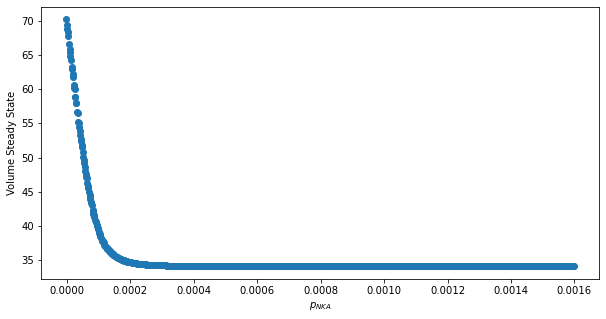

In [145]:
## Plotting in 2D

x_ax = (A[NaN_mask_array==1])/Ar1
y_ax = Y_A[NaN_mask_array==1]

plt.figure(figsize=(10,5))

plt.scatter(x_ax, y_ax)

plt.xlabel('$p_{NKA}$')
# plt.xticks(np.arange())
plt.ylabel('Volume Steady State')
# plt.legend(loc='best')

plt.show()

# Both Pump and One Cotransporter

## $P_{NKA}$ and $p_{NKCC}$

Searching for the minimum $w_{ss}$ in $p_{NKA}$ and $p_{NKCC}$.

Both $p_{KCC}$ and $p_{NCC}$ are set to zero.

### Collect samples

In [ ]:
samples_in_each_range_size = 50

pnka_max = 5*pnka
pnkcc_max = 1.5*pnkcc
pkcc_max = 0*pkcc
pncc_max = 0*pncc

pnka_array  = np.linspace(0, pnka_max, samples_in_each_range_size)
pnkcc_array = np.linspace(0, pnkcc_max, samples_in_each_range_size)
pkcc_array  = np.zeros(samples_in_each_range_size)
pncc_array  = np.zeros(samples_in_each_range_size)

group_1 = np.zeros((samples_in_each_range_size**2, 4))

k = 0
for nka in pnka_array:
    for nkcc in pnkcc_array:
        group_1[k,0] = nka
        group_1[k,1] = nkcc
        k=k+1

group_2 = np.hstack((
    np.random.uniform(low=0, high=pnka_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pnkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pncc_max, size=(samples_in_each_range_size**2,1))
))

wss_array = np.ones((samples_in_each_range_size**2,1))

parameter_arrays_list = [pnka_array,
                        pnkcc_array,
                        pkcc_array,
                        pncc_array]

## Collect samples
for index, parameter_point in enumerate(group_1):
    wss_array[index] = CollectSample(parameter_point,
                                     params)

## Normalize steady state volume
wss_array = 100*wss_array/wA0

### 2D plots

Each volume steady state, collected above, is represented by a grey dot. Fixing the parameter value, steady states are avergaed and plotted by a blue dot. 

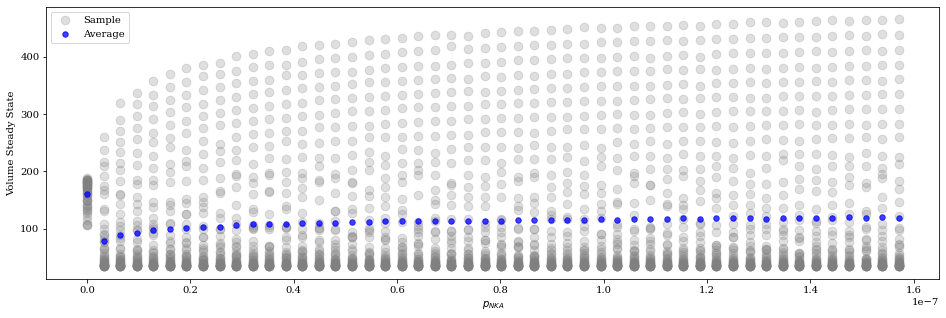

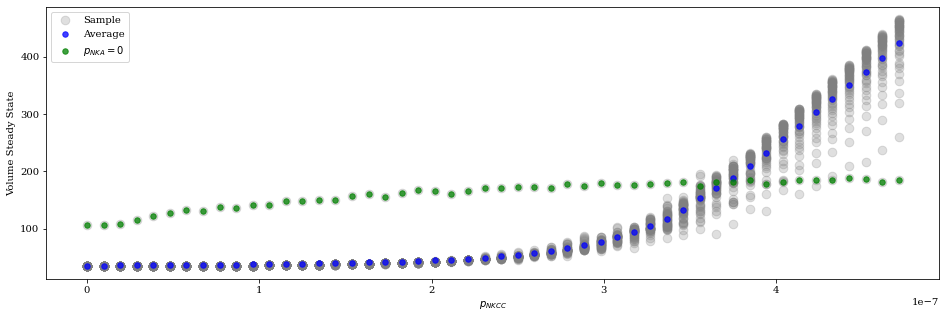

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for nka in range(samples_in_each_range_size):
    for nkcc in range(samples_in_each_range_size):
        wss_tensor[nka,nkcc] = wss_array[index]
        index += 1


## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$']

x_ax = group_1

for parameter in range(len(parameter_labels)):
    if parameter!=2 and parameter!=3:
        plt.figure(figsize=(16,5))
        
        # Samples
        plt.scatter(x_ax[:,parameter], wss_array, s=75, label='Sample', color='gray', alpha=0.25)

        # Average of samples
        avg_array = np.array([])
        for param_value in parameter_arrays_list[parameter]:
            avg_array = np.append(avg_array, np.mean(wss_array[np.argwhere(x_ax[:,parameter] == param_value)]))
        plt.scatter(parameter_arrays_list[parameter], avg_array, s=30, label='Average', color='blue', alpha=.75)

        # Pump is off
        if parameter!=0:
            plt.scatter(parameter_arrays_list[parameter], wss_tensor[0,:],  s=30, label='$p_{NKA}=0$', color='green', alpha=.75)
        
        
            
        plt.xlabel(parameter_labels[parameter])
        plt.ylabel('Volume Steady State')
        plt.legend(loc='best')
        plt.show()

### Heatmap

Minimum W_{SS} = 34.09578055631812 
found at: 
p_{NKA} = 3.20570678937734e-09 
p_{NKCC} = 0.0


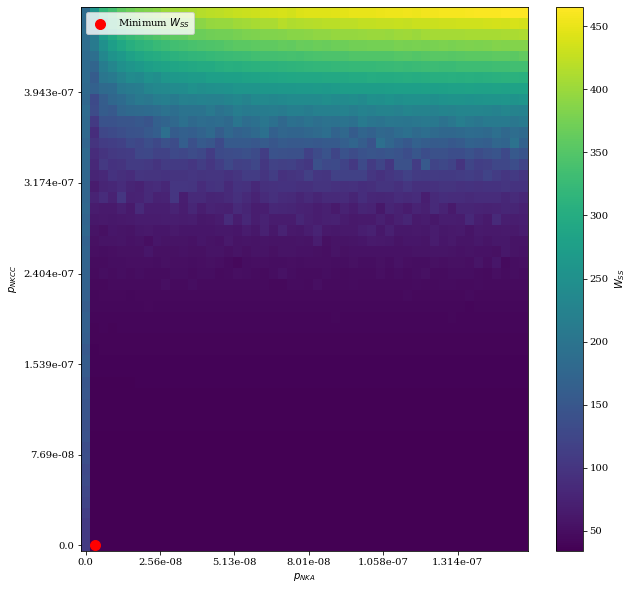

In [ ]:
heatmap = np.ones((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for x, nka_val in enumerate(pnka_array):
    for y, nkcc_val in enumerate(pnkcc_array):
        heatmap[y,x] = wss_array[index]
        index += 1

# Minimum steady state volume
mask2 = np.argwhere(wss_array.flatten()==np.nanmin(wss_array.flatten()))
min_point = group_1[mask2.flatten()].flatten()


print('Minimum W_{SS} =', np.min(wss_array.flatten()),
      '\nfound at:', 
      '\np_{NKA} =',min_point[0],
      '\np_{NKCC} =',min_point[1],
    #   '\np_{KCC} =',min_point[2],
    #   '\np_{NCC} =',min_point[3]
      )

plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{NKCC}$')

# Plot heatmap of volume
plt.imshow(heatmap, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pnkcc_array==min_point[1])[0], c='red', s=100, label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

## $p_{KCC}$

Searching for the minimum $w_{ss}$ in $p_{NKA}$ and $p_{KCC}$.

### Collect samples

In [ ]:
samples_in_each_range_size = 50

pnka_max = 0.05*pnka
pnkcc_max = 0*pnkcc
pkcc_max = 0*pkcc
pncc_max = 0*pncc

pnka_array  = np.linspace(0.001*pnka, pnka_max, samples_in_each_range_size)
pnkcc_array = np.zeros(samples_in_each_range_size)
pkcc_array  = np.linspace(0, pkcc_max, samples_in_each_range_size)
pncc_array  = np.zeros(samples_in_each_range_size)

group_1 = np.zeros((samples_in_each_range_size**2, 4))

k = 0
for nka in pnka_array:
    for kcc in pkcc_array:
        group_1[k,0] = nka
        group_1[k,2] = kcc
        k=k+1

group_2 = np.hstack((
    np.random.uniform(low=0, high=pnka_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pnkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pncc_max, size=(samples_in_each_range_size**2,1))
))

wss_array = np.ones((samples_in_each_range_size**2,1))

parameter_arrays_list = [pnka_array,
                        pnkcc_array,
                        pkcc_array,
                        pncc_array]

## Collect samples
for index, parameter_point in enumerate(group_1):
    wss_array[index] = CollectSample(parameter_point,
                                     params)
    
## Normalize steady state volume
wss_array = 100*wss_array/wA0

### 2D plot

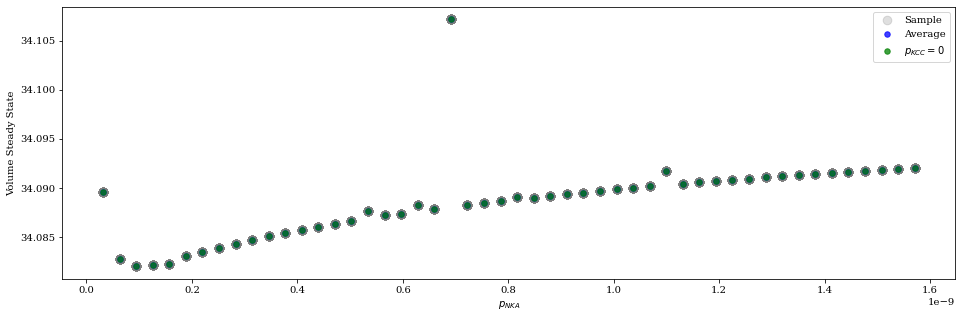

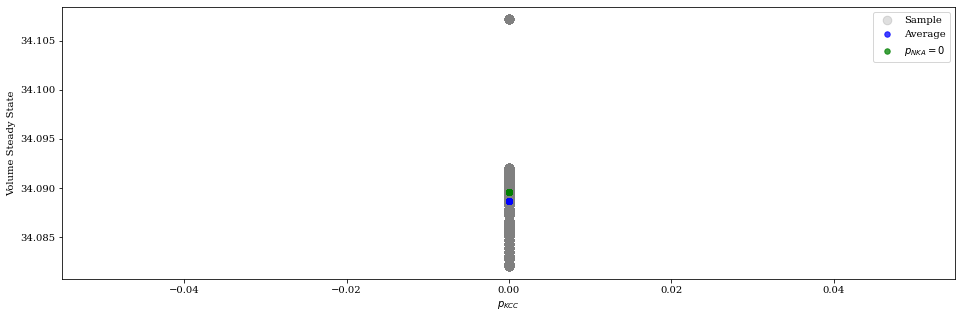

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for nka in range(samples_in_each_range_size):
    for kcc in range(samples_in_each_range_size):
        wss_tensor[nka,kcc] = wss_array[index]
        index += 1


## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$']

x_ax = group_1

for parameter in range(len(parameter_labels)):
    if parameter!=1 and parameter!=3:
        plt.figure(figsize=(16,5))
        
        # Samples
        plt.scatter(x_ax[:,parameter], wss_array, s=75, label='Sample', color='gray', alpha=0.25)

        # Average of samples
        avg_array = np.array([])
        for param_value in parameter_arrays_list[parameter]:
            avg_array = np.append(avg_array, np.mean(wss_array[np.argwhere(x_ax[:,parameter] == param_value)]))
        plt.scatter(parameter_arrays_list[parameter], avg_array, s=30, label='Average', color='blue', alpha=.75)

        # Pump is off
        if parameter!=0:
            plt.scatter(parameter_arrays_list[parameter], wss_tensor[0,:],  s=30, label='$p_{NKA}=0$', color='green', alpha=.75)

        # C is off
        if parameter!=2:
            plt.scatter(parameter_arrays_list[parameter], wss_tensor[:,0],  s=30, label='$p_{KCC}=0$', color='green', alpha=.75)
            
        plt.xlabel(parameter_labels[parameter])
        plt.ylabel('Volume Steady State')
        plt.legend(loc='best')
        plt.show()

### Heatmap

Miniumum W_{SS} = 33.94932631098695 
found at: 
p_{NKA} = 1.0469838374106391e-07 
p_{KCC} = 3.0133643820146993e-07


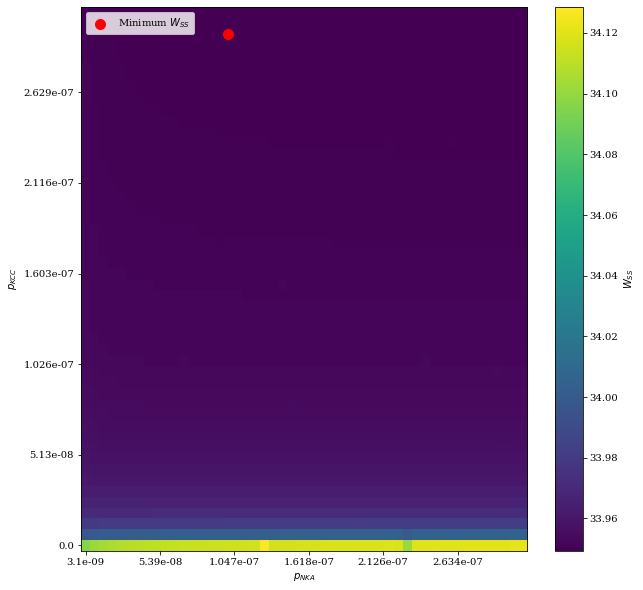

In [ ]:
heatmap = np.ones((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for x, nka_val in enumerate(pnka_array):
    for y, kcc_val in enumerate(pkcc_array):
        heatmap[y,x] = wss_array[index]
        index += 1

# Minimum steady state volume
mask = np.argwhere(wss_array.flatten()==np.nanmin(wss_array.flatten()))
min_point = group_1[mask.flatten()].flatten()

print('Miniumum W_{SS} =', np.min(wss_array.flatten()),
      '\nfound at:', 
      '\np_{NKA} =',min_point[0],
    #   '\np_{NKCC} =',min_point[1],
      '\np_{KCC} =',min_point[2],
    #   '\np_{NCC} =',min_point[3]
      )

plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{KCC}$')

# Plot heatmap of volume
plt.imshow(heatmap, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pkcc_array==min_point[2])[0], c='red', s=100, label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

## $p_{NCC}$

Searching for the minimum $w_{ss}$ in $p_{NKA}$ and $p_{NCC}$.

### Collect samples

In [ ]:
samples_in_each_range_size = 50

pnka_max = 1.5*pnka
pnkcc_max = 0*pnkcc
pkcc_max = 0*pkcc
pncc_max = .012*pncc

pnka_array  = np.linspace(0, pnka_max, samples_in_each_range_size)
pnkcc_array = np.zeros(samples_in_each_range_size)
pkcc_array  = np.zeros(samples_in_each_range_size)
pncc_array  = np.linspace(0, pncc_max, samples_in_each_range_size)

group_1 = np.zeros((samples_in_each_range_size**2, 4))

k = 0
for nka in pnka_array:
    for ncc in pncc_array:
        group_1[k,0] = nka
        group_1[k,3] = ncc
        k=k+1

group_2 = np.hstack((
    np.random.uniform(low=0, high=pnka_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pnkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pkcc_max, size=(samples_in_each_range_size**2,1)),
    np.random.uniform(low=0, high=pncc_max, size=(samples_in_each_range_size**2,1))
))

wss_array = np.ones((samples_in_each_range_size**2,1))

parameter_arrays_list = [pnka_array,
                        pnkcc_array,
                        pkcc_array,
                        pncc_array]

## Collect samples
for index, parameter_point in enumerate(group_1):
    wss_array[index] = CollectSample(parameter_point,
                                     params)
    
## Normalize steady state volume
wss_array = 100*wss_array/wA0

### 2D plots

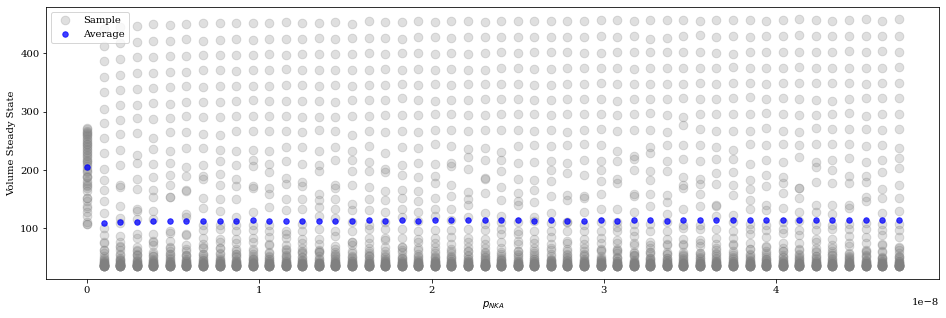

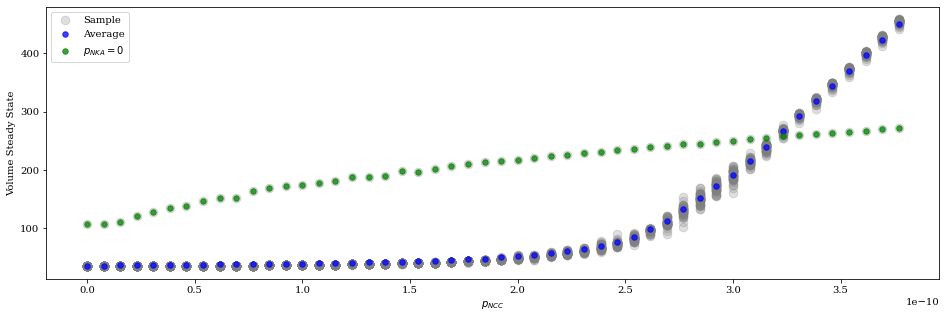

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for nka in range(samples_in_each_range_size):
    for ncc in range(samples_in_each_range_size):
        wss_tensor[nka,ncc] = wss_array[index]
        index += 1


## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$']

x_ax = group_1

for parameter in range(len(parameter_labels)):
    if parameter!=1 and parameter!=2:
        plt.figure(figsize=(16,5))
        
        # Samples
        plt.scatter(x_ax[:,parameter], wss_array, s=75, label='Sample', color='gray', alpha=0.25)

        # Average of samples
        avg_array = np.array([])
        for param_value in parameter_arrays_list[parameter]:
            avg_array = np.append(avg_array, np.mean(wss_array[np.argwhere(x_ax[:,parameter] == param_value)]))
        plt.scatter(parameter_arrays_list[parameter], avg_array, s=30, label='Average', color='blue', alpha=.75)

        # Pump is off
        if parameter!=0:
            plt.scatter(parameter_arrays_list[parameter], wss_tensor[0,:],  s=30, label='$p_{NKA}=0$', color='green', alpha=.75)
            
        plt.xlabel(parameter_labels[parameter])
        plt.ylabel('Volume Steady State')
        plt.legend(loc='best')
        plt.show()

In [ ]:
print(wss_tensor[:,-1])

[271.50551925 441.60366419 445.58591461 447.67513367 449.84192826
 448.64309833 450.51704111 451.60601873 451.84082791 452.36470335
 452.42366325 453.00232713 453.50782172 451.82366682 452.82771846
 454.36906982 450.08145301 455.31546159 454.64074217 454.7439144
 455.32731331 454.09512055 455.62076774 455.44565528 454.70315759
 455.93437681 456.30185668 456.28764102 455.31957501 456.52661595
 455.3646789  456.90566687 456.85169092 456.37436371 457.15369984
 456.8039222  456.64499907 456.19625711 457.50317463 457.18941597
 456.83423617 456.49859603 457.90659915 458.51777432 456.61272411
 456.06138045 457.88240603 458.30458945 456.29020072 458.27604359]


### Heatmap

Miniumum W_{SS} = 34.07697970368011 
found at: 
p_{NKA} = 6.7319842576924135e-09 
p_{NCC} = 0.0


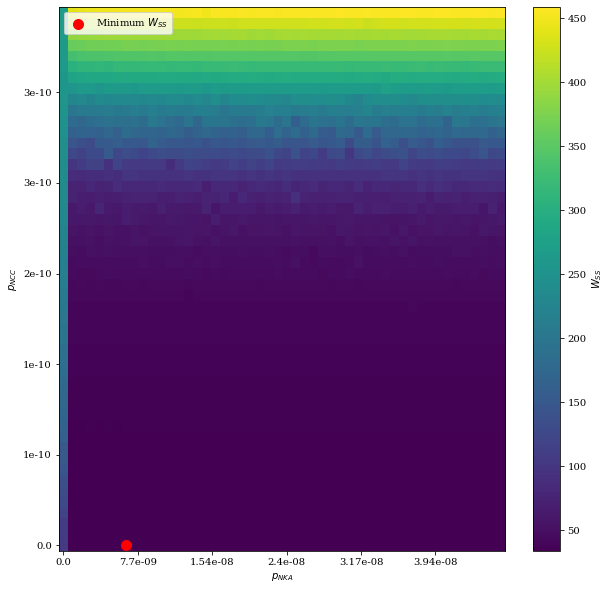

In [ ]:
heatmap = np.ones((samples_in_each_range_size,samples_in_each_range_size))

index = 0
for x, nka_val in enumerate(pnka_array):
    for y, ncc_val in enumerate(pncc_array):
        heatmap[y,x] = wss_array[index]
        index += 1

# Minimum steady state volume
mask = np.argwhere(wss_array.flatten()==np.nanmin(wss_array.flatten()))
min_point = group_1[mask.flatten()].flatten()

print('Miniumum W_{SS} =', np.min(wss_array.flatten()),
      '\nfound at:', 
      '\np_{NKA} =',min_point[0],
    #   '\np_{NKCC} =',min_point[1],
    #   '\np_{KCC} =',min_point[2],
      '\np_{NCC} =',min_point[3]
      )

plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pncc_array),6,endpoint=False), 
    np.round(pncc_array[np.linspace(0,len(pncc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{NCC}$')

# Plot heatmap of volume
plt.imshow(heatmap, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pncc_array==min_point[3])[0], c='red', s=100, label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

# Collect samples - $p_{NKCC}$ and $p_{KCC}$

Searching for the minimum $w_{ss}$ in
* $p_{NKA}, p_{NKCC}$,
* $p_{NKA}, p_{KCC}$, and 
* $p_{NKCC}, p_{KCC}$

In [ ]:
samples_in_each_range_size = 20
sample_size = samples_in_each_range_size**3

pnka_max = 0.05*pnka
pnkcc_max = 1.5*pnkcc
pkcc_max = 1.5*pkcc
pncc_max = 0*pncc

pnka_array  = np.linspace(0, pnka_max, samples_in_each_range_size)
pnkcc_array = np.linspace(0, pnkcc_max, samples_in_each_range_size)
pkcc_array  = np.linspace(0, pkcc_max, samples_in_each_range_size)
pncc_array  = np.zeros(samples_in_each_range_size)

group_1 = np.zeros((sample_size, 4))

k = 0
for nka in pnka_array:
    for nkcc in pnkcc_array:
        for kcc in pkcc_array:
            group_1[k,0] = nka
            group_1[k,1] = nkcc
            group_1[k,2] = kcc
            k=k+1
group_2 = np.hstack((
    np.random.uniform(low=0, high=pnka_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pnkcc_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pkcc_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pncc_max, size=(sample_size,1))
))

wss_array = np.ones((sample_size,1))

parameter_arrays_list = [pnka_array,
                        pnkcc_array,
                        pkcc_array,
                        pncc_array]
                        
# sample_each_value_size = 100
# samples_in_each_range_size = 1000
# sample_size = sample_each_value_size * samples_in_each_range_size

# pnka_array  = np.linspace(0, pnka*1e+1, samples_in_each_range_size)
# pnkcc_array = np.linspace(0, pnkcc*1e+1, samples_in_each_range_size)
# pkcc_array  = np.linspace(0, pkcc*1e+1, samples_in_each_range_size)
# pncc_array  = np.zeros(samples_in_each_range_size)

# group_1 = np.hstack((
#     repeat_rand(pnka_array, sample_each_value_size),
#     repeat_rand(pnkcc_array, sample_each_value_size),
#     repeat_rand(pkcc_array, sample_each_value_size),
#     repeat_rand(pncc_array, sample_each_value_size)
# ))
# group_2 = np.hstack((
#     np.random.uniform(low=0, high=pnka*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pnkcc*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pkcc*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pncc*1e+1, size=(sample_size,1))
# ))

# wss_array = np.ones((sample_size,1))

# parameter_arrays_list = [pnka_array,
#                         pnkcc_array,
#                         pkcc_array,
#                         pncc_array]

In [ ]:
## Collect samples
for index, parameter_point in enumerate(group_1):
    wss_array[index] = CollectSample(parameter_point,
                                     params)

In [ ]:
## Normalize steady state volume
wss_array = 100*wss_array/wA0

## 2D plots

In [ ]:
none_nan_mask = np.argwhere(np.isfinite(wss_array.flatten())).flatten()

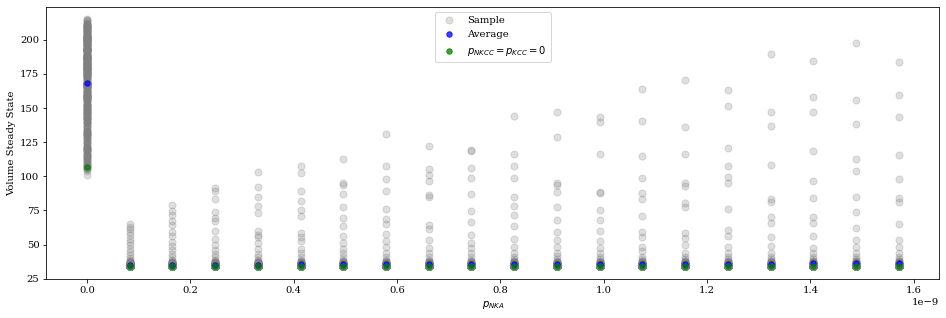

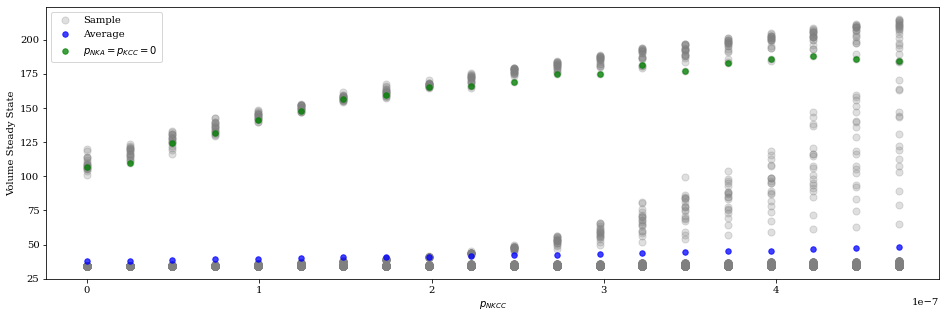

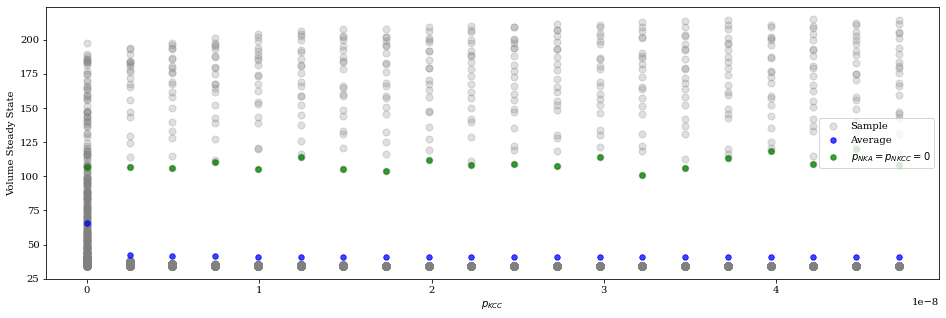

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,samples_in_each_range_size,samples_in_each_range_size))

index = 0
for nka in range(samples_in_each_range_size):
    for nkcc in range(samples_in_each_range_size):
        for kcc in range(samples_in_each_range_size):
            wss_tensor[nka,nkcc,kcc] = wss_array[index]
            index += 1

## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$']

x_ax = group_1[none_nan_mask]
y_ax = wss_array[none_nan_mask]

for parameter in range(len(parameter_labels)):
    plt.figure(figsize=(16,5))
    plt.scatter(x_ax[:,parameter], y_ax, s=50, label='Sample', color='gray', alpha=0.25)

    # Average
    avg_array = np.array([])
    for param_value in parameter_arrays_list[parameter]:
        avg_array = np.append(avg_array, np.mean(y_ax[np.argwhere(x_ax[:,parameter] == param_value)]))
    plt.scatter(parameter_arrays_list[parameter], avg_array, s=30, label='Average', color='blue', alpha=.75)

    # Pump/cotransporter(s) off
    if parameter!=1 and parameter!=2:
        plt.scatter(parameter_arrays_list[parameter], wss_tensor[:,0,0],  s=30, label='$p_{NKCC}=p_{KCC}=0$', color='green', alpha=.75)
    if parameter!=0 and parameter!=2:
        plt.scatter(parameter_arrays_list[parameter], wss_tensor[0,:,0],  s=30, label='$p_{NKA}=p_{KCC}=0$', color='green', alpha=.75)
    if parameter!=0 and parameter!=1:
        plt.scatter(parameter_arrays_list[parameter], wss_tensor[0,0,:],  s=30, label='$p_{NKA}=p_{NKCC}=0$', color='green', alpha=.75)

    plt.xlabel(parameter_labels[parameter])
    plt.ylabel('Volume Steady State')
    plt.legend(loc='best')
    # plt.semilogy()
    plt.show()


## Heatmaps

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,
                       samples_in_each_range_size,
                       samples_in_each_range_size))

In [ ]:
index = 0
for nka in range(samples_in_each_range_size):
    for nkcc in range(samples_in_each_range_size):
        for kcc in range(samples_in_each_range_size):
            wss_tensor[nka,nkcc,kcc] = wss_array[index]
            index+=1

In [ ]:
# Minimum steady state volume
mask = np.argwhere(wss_array.flatten()==np.nanmin(wss_array.flatten()))
min_point = group_1[mask.flatten()].flatten()

In [ ]:
mask2 = np.argwhere(wss_tensor==np.nanmin(wss_tensor)).flatten()

In [ ]:
# Create nka,nkcc heatmap array
heatmap_nka_nkcc = wss_tensor[:,:,mask2[2]].T

# Create nka,kcc heatmap array
heatmap_nka_kcc = wss_tensor[:,mask2[1],:].T

# Create nkcc,kcc heatmap array
heatmap_nkcc_kcc = wss_tensor[mask2[0],:,:].T

Minimum W_{SS} = 33.963933687495015 
found at: 
p_{NKA} = 1.000000077504836 
p_{NKCC} = 0.0 
p_{KCC} = 4.712388980384689e-08


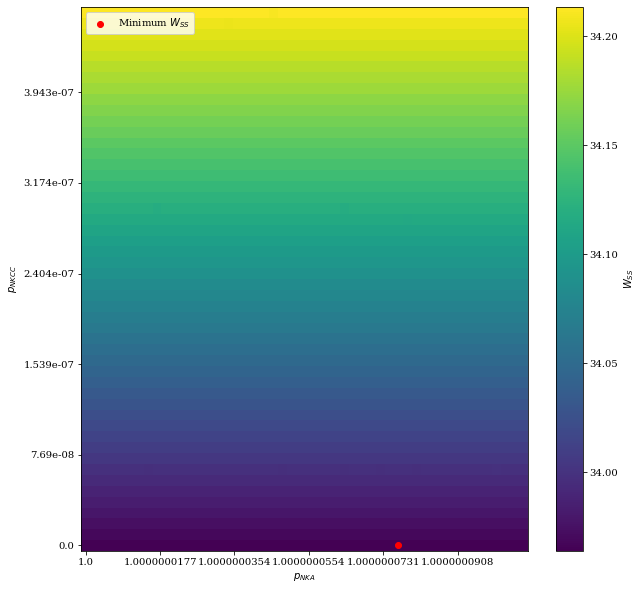

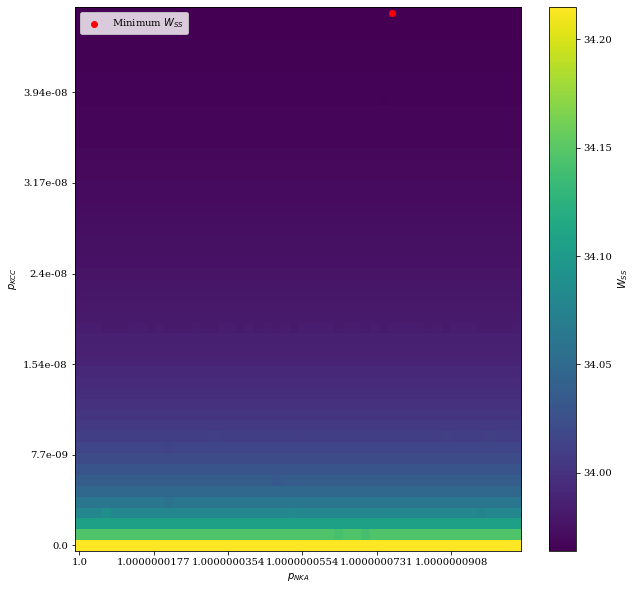

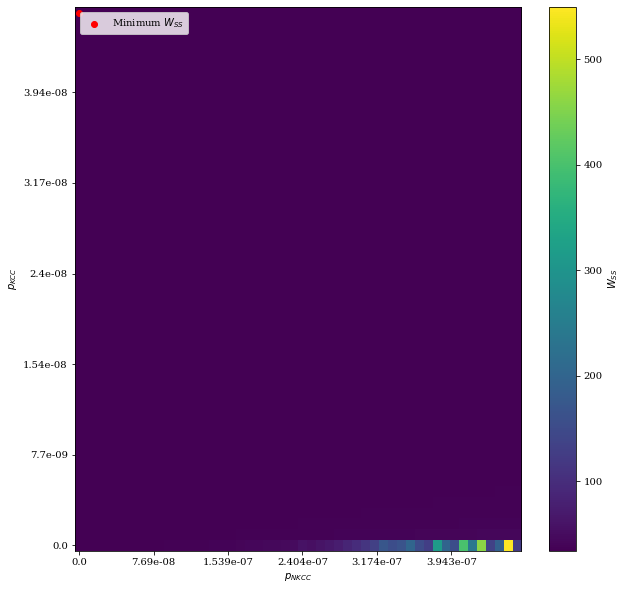

In [ ]:
print('Minimum W_{SS} =', np.nanmin(wss_array.flatten()),
      '\nfound at:', 
      '\np_{NKA} =',min_point[0],
      '\np_{NKCC} =',min_point[1],
      '\np_{KCC} =',min_point[2]
      )

###############
# NKA, NKCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{NKCC}$')

# Plot heatmap_nka_nkcc of volume
plt.imshow(heatmap_nka_nkcc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pnkcc_array==min_point[1])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()


###############
# NKA, KCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{KCC}$')

# Plot heatmap_nka_kcc of volume
plt.imshow(heatmap_nka_kcc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pkcc_array==min_point[2])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()


###############
# NKCC, KCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKCC}$')
plt.ylabel('$p_{KCC}$')

# Plot heatmap_nka_nkcc of volume
plt.imshow(heatmap_nkcc_kcc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnkcc_array==min_point[1])[0],np.argwhere(pkcc_array==min_point[2])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

# Collect samples - $p_{NKCC}$, $p_{KCC}$, and $p_{NCC}$

Searching for the minimum $w_{ss}$ in
* $p_{NKA}, p_{NKCC}$,
* $p_{NKA}, p_{KCC}$,
* $p_{NKA}, p_{NCC}$
* $p_{NKCC}, p_{KCC}$,
* $p_{NKCC}, p_{NCC}$,
* $p_{KCC}, p_{NCC}$

In [30]:
samples_in_each_range_size = 50
sample_size = samples_in_each_range_size**4

pnka_max = pnka
pnkcc_max = 1.5*pnkcc
pkcc_max = 0.0125*pkcc
pncc_max = 1.5*pncc

pnka_array  = np.linspace(0, pnka_max, samples_in_each_range_size)
pnkcc_array = np.linspace(0, pnkcc_max, samples_in_each_range_size)
pkcc_array  = np.linspace(0, pkcc_max, samples_in_each_range_size)
pncc_array  = np.linspace(0, pncc_max, samples_in_each_range_size)

group_1 = np.zeros((sample_size, 4))

k = 0
for nka in pnka_array:
    for nkcc in pnkcc_array:
        for kcc in pkcc_array:
            for ncc in pncc_array:
                group_1[k,0] = nka
                group_1[k,1] = nkcc
                group_1[k,2] = kcc
                group_1[k,3] = ncc
                k=k+1
group_2 = np.hstack((
    np.random.uniform(low=0, high=pnka_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pnkcc_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pkcc_max, size=(sample_size,1)),
    np.random.uniform(low=0, high=pncc_max, size=(sample_size,1))
))

wss_array = np.ones((sample_size,1))
NaN_array = np.zeros(sample_size, dtype=int).flatten()

parameter_arrays_list = [pnka_array,
                        pnkcc_array,
                        pkcc_array,
                        pncc_array]

# sample_each_value_size = 100
# samples_in_each_range_size = 1000
# sample_size = sample_each_value_size * samples_in_each_range_size

# pnka_array  = np.linspace(0, pnka*1e+1, samples_in_each_range_size)
# pnkcc_array = np.linspace(0, pnkcc*1e+1, samples_in_each_range_size)
# pkcc_array  = np.linspace(0, pkcc*1e+1, samples_in_each_range_size)
# pncc_array  = np.linspace(0, pncc*1e+1, samples_in_each_range_size)

# group_1 = np.hstack((
#     repeat_rand(pnka_array, sample_each_value_size),
#     repeat_rand(pnkcc_array, sample_each_value_size),
#     repeat_rand(pkcc_array, sample_each_value_size),
#     repeat_rand(pncc_array, sample_each_value_size)
# ))
# group_2 = np.hstack((
#     np.random.uniform(low=0, high=pnka*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pnkcc*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pkcc*1e+1, size=(sample_size,1)),
#     np.random.uniform(low=0, high=pncc*1e+1, size=(sample_size,1))
# ))

# wss_array = np.ones((sample_size,1))

# parameter_arrays_list = [pnka_array,
#                         pnkcc_array,
#                         pkcc_array,
#                         pncc_array]

In [32]:
## Collect samples
for index, parameter_point in enumerate(group_1):
    params.pnka = parameter_point[0]
    params.pnkcc = parameter_point[1]
    params.pkcc = parameter_point[2]
    params.pncc = parameter_point[3]
    wss_array[index], NaN_array[index] = CollectSample(params)

# 1967005/(206+(58.2/60)) = 9502.43961353 iterations per minute

C:\Users\LENOVO~1\AppData\Local\Temp/ipykernel_14660/3552223522.py:50: RuntimeWarning: invalid value encountered in log
  EnaA = (R)*np.log(na_e/naA)
C:\Users\LENOVO~1\AppData\Local\Temp/ipykernel_14660/3552223522.py:52: RuntimeWarning: invalid value encountered in log
  EclA = -(R)*np.log(cl_e/clA)
C:\Users\LENOVO~1\AppData\Local\Temp/ipykernel_14660/3552223522.py:51: RuntimeWarning: invalid value encountered in log
  EkA  = (R)*np.log(k_e/kA)


KeyboardInterrupt: 

In [ ]:
wss_array = 100*wss_array/wA0

In [ ]:
# Degree 1
var_list =[]
var_list.append(np.reshape(wss_array[:,0],(-1,1)))
var_list.append(np.reshape(wss_array[:,1],(-1,1)))
var_list.append(np.reshape(wss_array[:,2],(-1,1)))
var_list.append(np.reshape(wss_array[:,3],(-1,1)))
grp = [' x0',' x1',' x2',' x3']

X = np.hstack(*[var for var in var_list],np.ones(Nsamples))



In [ ]:
# Degree 2
var_list =[]
var_list.append(wss_array[:,0])
var_list.append(wss_array[:,1])
var_list.append(wss_array[:,2])
var_list.append(wss_array[:,3])
grp = [' x0',' x1',' x2',' x3']

tri_num = 20

for i in range(tri_num):
    for j in range(tri_num):
        var_list.append(np.reshape(var_list[i]*var_list[j],(-1,1)))
        grp.append(grp[i]+grp[j])

X = np.hstack(*[var for var in var_list],np.ones(Nsamples))



## 2D plots

In [ ]:
for i in range(4):
        

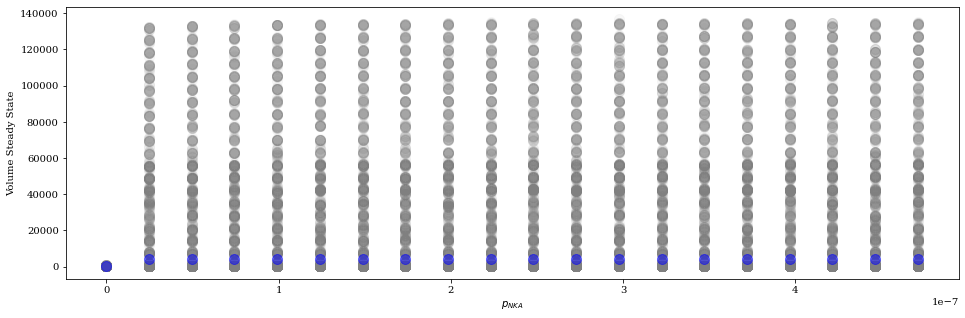

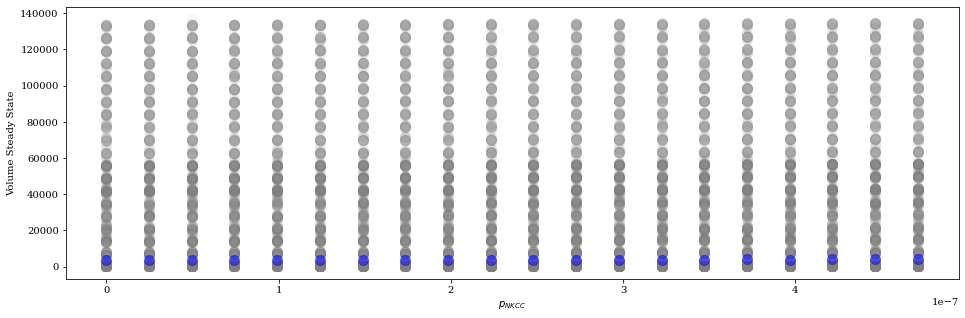

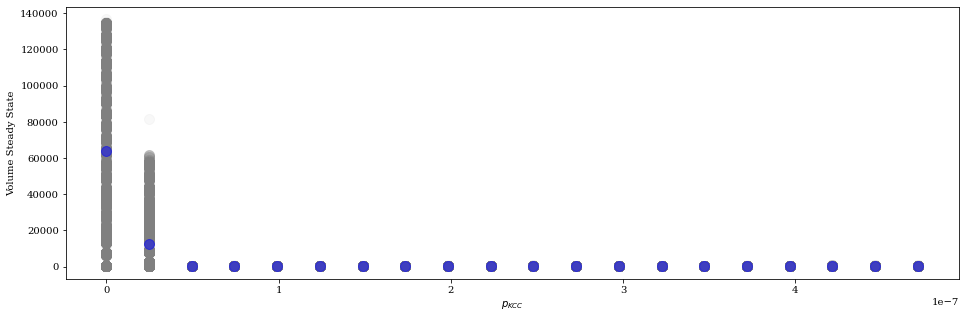

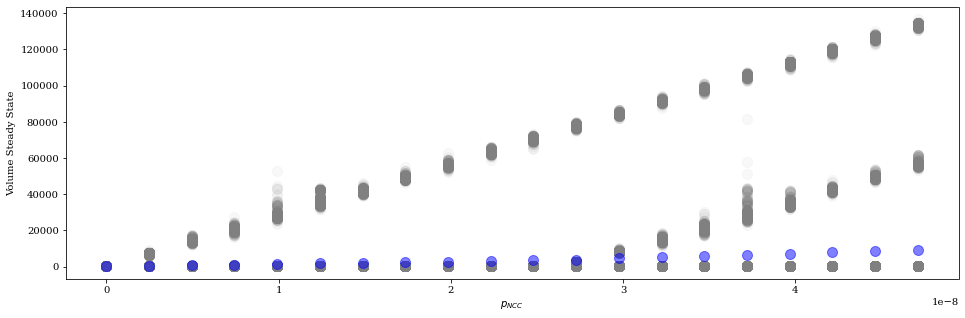

In [ ]:
# Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$']

x_ax = group_1[NaN_array]
y_ax = wss_array[NaN_array]

for parameter in range(len(parameter_labels)):
    plt.figure(figsize=(16,5))
    # avg_bp = np.poly1d(np.polyfit(x_ax[:,parameter],np.array(fast_burst_period_list),2))(x_ax[:,parameter])
    plt.scatter(x_ax[:,parameter], y_ax, s=100, label='', color='gray', alpha=0.05)
    for param_value in parameter_arrays_list[parameter]:
        avg = np.mean(y_ax[np.argwhere(x_ax[:,parameter] == param_value)])
        plt.scatter(param_value, avg, s=100, label='', color='blue', alpha=.5)
    plt.xlabel(parameter_labels[parameter])
    plt.ylabel('Volume Steady State')
    # plt.legend(loc='upper left')
    # plt.semilogx()
    plt.show()


## Heatmaps

In [ ]:
wss_tensor = np.zeros((samples_in_each_range_size,
                       samples_in_each_range_size,
                       samples_in_each_range_size,
                       samples_in_each_range_size))

In [ ]:
index = 0
for nka in range(samples_in_each_range_size):
    for nkcc in range(samples_in_each_range_size):
        for kcc in range(samples_in_each_range_size):
            for ncc in range(samples_in_each_range_size):
                wss_tensor[nka,nkcc,kcc,ncc] = wss_array[index]
                index+=1

In [ ]:
# Minimum steady state volume
mask = np.argwhere(wss_array.flatten()==np.nanmin(wss_array.flatten()))
min_point = group_1[mask.flatten()].flatten()

In [ ]:
mask2 = np.argwhere(wss_tensor==np.nanmin(wss_tensor)).flatten()

In [ ]:
# Create nka,nkcc heatmap array
# heatmap_nka_nkcc = np.nanmean(wss_tensor, axis=(2,3))
heatmap_nka_nkcc = wss_tensor[:,:,mask2[2],mask2[3]].T

# Create nka,kcc heatmap array
# heatmap_nka_kcc = np.nanmean(wss_tensor, axis=(1,3))
heatmap_nka_kcc = wss_tensor[:,mask2[1],:,mask2[3]].T

# Create nka,ncc heatmap array
# heatmap_nka_ncc = np.nanmean(wss_tensor, axis=(1,2))
heatmap_nka_ncc = wss_tensor[:,mask2[1],mask2[2],:].T

# Create nkcc,kcc heatmap array
# heatmap_nkcc_kcc = np.nanmean(wss_tensor, axis=(0,3))
heatmap_nkcc_kcc = wss_tensor[mask2[0],:,:,mask2[3]].T

# Create nkcc,ncc heatmap array
# heatmap_nkcc_ncc = np.nanmean(wss_tensor, axis=(0,2))
heatmap_nkcc_ncc = wss_tensor[mask2[0],:,mask2[2],:].T

# Create kcc,ncc heatmap array
# heatmap_kcc_ncc = np.nanmean(wss_tensor, axis=(0,1))
heatmap_kcc_ncc = wss_tensor[mask2[0],mask2[1],:,:].T

Minimum W_{SS} = 33.94870565704855 
found at: 
p_{NKA} = 4.7123889803846896e-07 
p_{NKCC} = 0.0 
p_{KCC} = 4.7123889803846896e-07 
p_{NCC} = 0.0


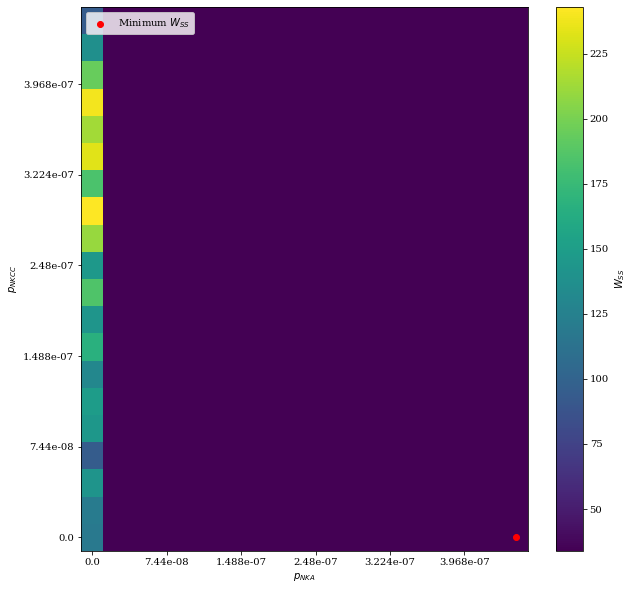

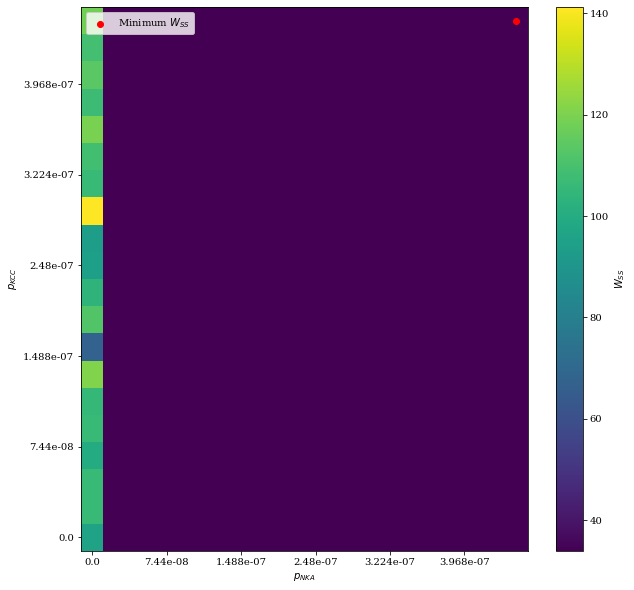

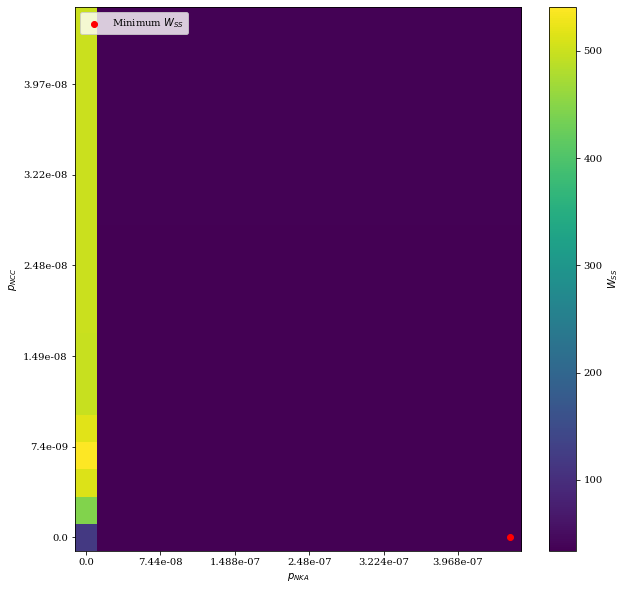

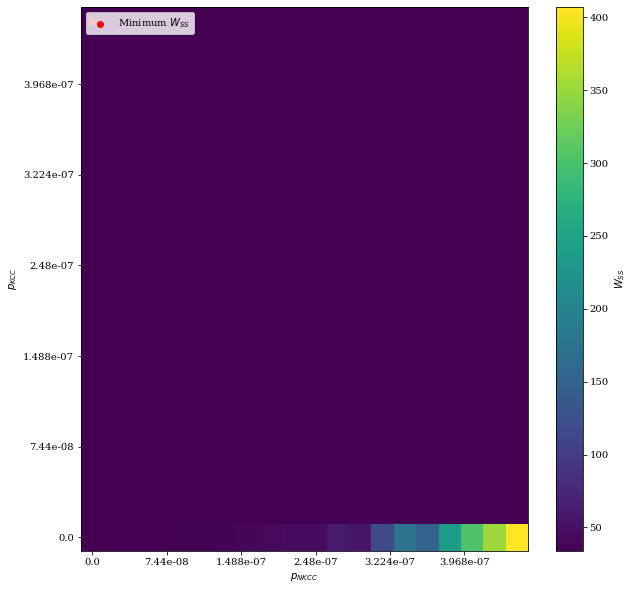

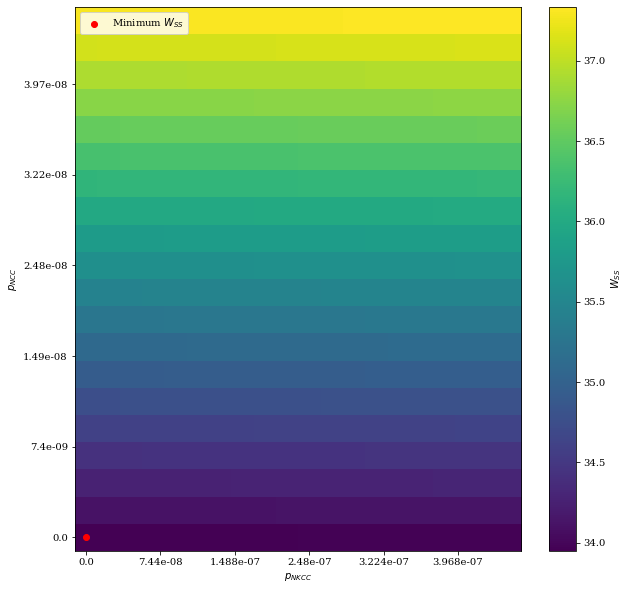

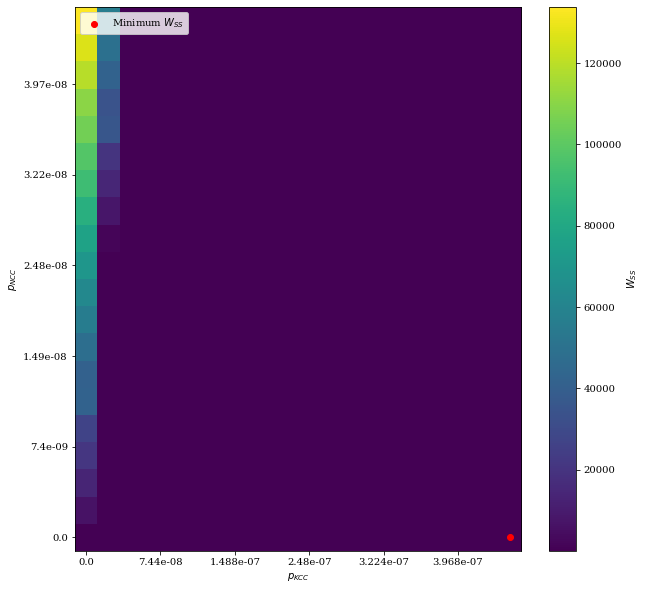

In [ ]:
print('Minimum W_{SS} =', np.nanmin(wss_array.flatten()),
      '\nfound at:', 
      '\np_{NKA} =',min_point[0],
      '\np_{NKCC} =',min_point[1],
      '\np_{KCC} =',min_point[2],
      '\np_{NCC} =',min_point[3]
      )

###############
# NKA, NKCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{NKCC}$')

# Plot heatmap_nka_nkcc of volume
plt.imshow(np.abs(heatmap_nka_nkcc), aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(mask2[0],mask2[1], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()


###############
# NKA, KCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{KCC}$')

# Plot heatmap_nka_kcc of volume
plt.imshow(np.abs(heatmap_nka_kcc), aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pkcc_array==min_point[2])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

###############
# NKA, NCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnka_array),6,endpoint=False), 
    np.round(pnka_array[np.linspace(0,len(pnka_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pncc_array),6,endpoint=False), 
    np.round(pncc_array[np.linspace(0,len(pncc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKA}$')
plt.ylabel('$p_{NCC}$')

# Plot heatmap_nka_ncc of volume
plt.imshow(heatmap_nka_ncc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnka_array==min_point[0])[0],np.argwhere(pncc_array==min_point[3])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()


###############
# NKCC, NCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKCC}$')
plt.ylabel('$p_{KCC}$')

# Plot heatmap_nkcc_kcc of volume
plt.imshow(heatmap_nkcc_kcc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnkcc_array==min_point[1])[0],np.argwhere(pkcc_array==min_point[2])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()


###############
# NKCC, NCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pnkcc_array),6,endpoint=False), 
    np.round(pnkcc_array[np.linspace(0,len(pnkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pncc_array),6,endpoint=False), 
    np.round(pncc_array[np.linspace(0,len(pncc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{NKCC}$')
plt.ylabel('$p_{NCC}$')

# Plot heatmap_nka_nkcc of volume
plt.imshow(heatmap_nkcc_ncc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pnkcc_array==min_point[1])[0],np.argwhere(pncc_array==min_point[3])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()

###############
# KCC, NCC
###############
plt.figure(figsize=[10,10])

# Axes
plt.xticks(
    np.linspace(0,len(pkcc_array),6,endpoint=False), 
    np.round(pkcc_array[np.linspace(0,len(pkcc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.yticks(
    np.linspace(0,len(pncc_array),6,endpoint=False), 
    np.round(pncc_array[np.linspace(0,len(pncc_array),6,dtype=int,endpoint=False)],decimals=10)
    )
plt.xlabel('$p_{KCC}$')
plt.ylabel('$p_{NCC}$')

# Plot heatmap_kcc_ncc of volume
plt.imshow(heatmap_kcc_ncc, aspect='auto', origin='lower')

# Volume steady state color bar
plt.colorbar(label="$W_{SS}$")

# Plot min point
plt.scatter(np.argwhere(pkcc_array==min_point[2])[0],np.argwhere(pncc_array==min_point[3])[0], c='red', label='Minimum $W_{SS}$')
plt.legend(loc='upper left')

plt.show()